<a href="https://colab.research.google.com/github/b-fatma/S2I-DM/blob/master/src/merge/merge_4_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import geopandas as gpd
import pandas as pd
import csv
import sys
import geopandas as gpd
import shapely
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_path = '/content/drive/MyDrive/dm_fire_prediction/merge/fire_landcover_elevation_soil_no_na_climate.csv'

df = pd.read_csv(input_path)
df.head()

,longitude,latitude,fire,lcccode_label,elevation_ED_smoothed_by_mean,latitude_soil,longitude_soil,COARSE,SAND,SILT,...,prec_summer,prec_winter,tmax_autumn,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter
0,5.53337,35.70751,1,16.0,1787.5,35.707501,5.530728,13.5,41.0,34.5,...,19.675,115.025,19.416666,17.166666,29.666666,8.833333,10.000000,6.500000,16.250000,1.250000
1,6.46961,32.13579,1,19.0,-280.0,32.139236,6.472775,9.0,55.0,30.0,...,2.300,9.475,32.250000,31.666666,43.666668,19.750000,19.333334,16.916666,28.666666,6.666666
2,6.97630,32.35563,1,19.0,-280.0,32.347663,6.997986,12.0,57.0,27.0,...,2.200,10.425,32.000000,31.333334,43.333332,19.666666,19.250000,16.666666,28.333334,6.500000
3,9.39581,28.19791,1,18.0,581.0,28.195803,9.398955,12.0,57.0,27.0,...,1.000,8.950,31.666666,31.500000,41.333332,19.916666,16.666666,15.083333,25.000000,4.083334
4,9.49323,28.12826,1,18.0,581.0,28.129107,9.490658,12.0,57.0,27.0,...,1.000,8.200,31.666666,31.666666,41.333332,20.000000,17.000000,15.666667,25.500000,5.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   longitude                      float64
 1   latitude                       float64
 2   fire                           int64  
 3   lcccode_label                  float64
 4   elevation_ED_smoothed_by_mean  float64
 5   latitude_soil                  float64
 6   longitude_soil                 float64
 7   COARSE                         float64
 8   SAND                           float64
 9   SILT                           float64
 10  CLAY                           float64
 11  BULK                           float64
 12  REF_BULK                       float64
 13  ORG_CARBON                     float64
 14  PH_WATER                       float64
 15  TOTAL_N                        float64
 16  CN_RATIO                       float64
 17  CEC_SOIL                       float64
 18  CE

## Encode soil soter

In [ ]:
dummies = pd.get_dummies(df['TEXTURE_SOTER'], prefix='TEXTURE_SOTER')
df = pd.concat([df, dummies], axis=1)
df.drop(columns='TEXTURE_SOTER', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 43 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   longitude                      float64
 1   latitude                       float64
 2   fire                           int64  
 3   lcccode_label                  float64
 4   elevation_ED_smoothed_by_mean  float64
 5   latitude_soil                  float64
 6   longitude_soil                 float64
 7   COARSE                         float64
 8   SAND                           float64
 9   SILT                           float64
 10  CLAY                           float64
 11  BULK                           float64
 12  REF_BULK                       float64
 13  ORG_CARBON                     float64
 14  PH_WATER                       float64
 15  TOTAL_N                        float64
 16  CN_RATIO                       float64
 17  CEC_SOIL                       float64
 18  CE

## Fill Missing LCCCode Values

In [ ]:
df.isna().sum()

,0
longitude,0
latitude,0
fire,0
lcccode_label,931
elevation_ED_smoothed_by_mean,0
latitude_soil,0
longitude_soil,0
COARSE,0
SAND,0
SILT,0


In [ ]:
# fill with the value of the nearest neighbor
from sklearn.neighbors import BallTree
import numpy as np

def fill_missing_lcccode(df):
    missing_lcc_df = df[df['lcccode_label'].isna()]
    non_missing_lcc_df = df[~df['lcccode_label'].isna()]

    if non_missing_lcc_df.empty:
        return df

    # Prepare data for BallTree
    non_missing_coords = non_missing_lcc_df[['longitude', 'latitude']].values
    non_missing_lcc_values = non_missing_lcc_df['lcccode_label'].values

    # Create a BallTree
    tree = BallTree(np.radians(non_missing_coords), metric='haversine')

    for index, row in missing_lcc_df.iterrows():
        query_point = np.radians(row[['longitude', 'latitude']].values.reshape(1, -1))

        # Query the BallTree for the nearest neighbor
        distance, ind = tree.query(query_point, k=1)

        nearest_lcccode = non_missing_lcc_values[ind[0][0]]

        df.loc[index, 'lcccode_label'] = nearest_lcccode
    return df

In [ ]:
df = fill_missing_lcccode(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 43 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   longitude                      float64
 1   latitude                       float64
 2   fire                           int64  
 3   lcccode_label                  float64
 4   elevation_ED_smoothed_by_mean  float64
 5   latitude_soil                  float64
 6   longitude_soil                 float64
 7   COARSE                         float64
 8   SAND                           float64
 9   SILT                           float64
 10  CLAY                           float64
 11  BULK                           float64
 12  REF_BULK                       float64
 13  ORG_CARBON                     float64
 14  PH_WATER                       float64
 15  TOTAL_N                        float64
 16  CN_RATIO                       float64
 17  CEC_SOIL                       float64
 18  CE

## Drop Unnecessary Columns

In [ ]:
df.drop(columns=['longitude_soil', 'latitude_soil'], inplace=True)

## Converting to Appropriate Types

In [ ]:
df[[c for c in df.columns if c.startswith('TEXTURE_SOTER')]] = df[[c for c in df.columns if c.startswith('TEXTURE_SOTER')]].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   longitude                      float64
 1   latitude                       float64
 2   fire                           int64  
 3   lcccode_label                  float64
 4   elevation_ED_smoothed_by_mean  float64
 5   COARSE                         float64
 6   SAND                           float64
 7   SILT                           float64
 8   CLAY                           float64
 9   BULK                           float64
 10  REF_BULK                       float64
 11  ORG_CARBON                     float64
 12  PH_WATER                       float64
 13  TOTAL_N                        float64
 14  CN_RATIO                       float64
 15  CEC_SOIL                       float64
 16  CEC_CLAY                       float64
 17  CEC_EFF                        float64
 18  TE

In [ ]:
output_path = '/content/drive/MyDrive/dm_fire_prediction/merge/merged.csv'
df.to_csv(output_path, index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   longitude                      float64
 1   latitude                       float64
 2   fire                           int64  
 3   lcccode_label                  float64
 4   elevation_ED_smoothed_by_mean  float64
 5   COARSE                         float64
 6   SAND                           float64
 7   SILT                           float64
 8   CLAY                           float64
 9   BULK                           float64
 10  REF_BULK                       float64
 11  ORG_CARBON                     float64
 12  PH_WATER                       float64
 13  TOTAL_N                        float64
 14  CN_RATIO                       float64
 15  CEC_SOIL                       float64
 16  CEC_CLAY                       float64
 17  CEC_EFF                        float64
 18  TE

## Drop Lon Lat

In [ ]:
df_test = df.drop(columns=['longitude', 'latitude'])
df_test.drop_duplicates(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92947 entries, 0 to 1965240
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fire                           92947 non-null  int64  
 1   lcccode_label                  92947 non-null  float64
 2   elevation_ED_smoothed_by_mean  92947 non-null  float64
 3   COARSE                         92947 non-null  float64
 4   SAND                           92947 non-null  float64
 5   SILT                           92947 non-null  float64
 6   CLAY                           92947 non-null  float64
 7   BULK                           92947 non-null  float64
 8   REF_BULK                       92947 non-null  float64
 9   ORG_CARBON                     92947 non-null  float64
 10  PH_WATER                       92947 non-null  float64
 11  TOTAL_N                        92947 non-null  float64
 12  CN_RATIO                       92947 non-null  fl

In [ ]:
df_test['fire'].sum() / df_test.shape[0] * 100

np.float64(2.266883277566785)

In [ ]:
df_test.head()

,fire,lcccode_label,elevation_ED_smoothed_by_mean,COARSE,SAND,SILT,CLAY,BULK,REF_BULK,ORG_CARBON,...,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter,TEXTURE_SOTER_C,TEXTURE_SOTER_F,TEXTURE_SOTER_M
0,1,16.0,1787.5,13.5,41.0,34.5,24.5,1.425,1.775,2.1635,...,17.166666,29.666666,8.833333,10.000000,6.500000,16.250000,1.250000,0,0,1
1,1,19.0,-280.0,9.0,55.0,30.0,15.0,1.420,1.620,0.5890,...,31.666666,43.666668,19.750000,19.333334,16.916666,28.666666,6.666666,0,0,1
2,1,19.0,-280.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31.333334,43.333332,19.666666,19.250000,16.666666,28.333334,6.500000,0,0,1
3,1,18.0,581.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31.500000,41.333332,19.916666,16.666666,15.083333,25.000000,4.083334,0,0,1
4,1,18.0,581.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31.666666,41.333332,20.000000,17.000000,15.666667,25.500000,5.000000,0,0,1


In [ ]:
output_path2 = '/content/drive/MyDrive/dm_fire_prediction/merge/merged_no_duplicates.csv'
df_test.to_csv(output_path2, index=False)

## Playing Around with imbalance-learn

In [32]:
!pip install imblearn

In [44]:
y = df_test['fire']
X = df_test.drop(columns=['fire'])

In [45]:
X.shape, y.shape, y.sum()

((92947, 38), (92947,), np.int64(2107))

## Undersampling Non Fire Instances

### Random Under Sampler

((9130, 38), (9130,), np.int64(2107))

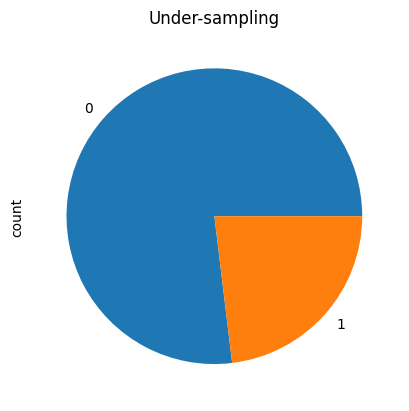

In [54]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 0.3
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
ax = y_res.value_counts().plot.pie()
_ = ax.set_title("Under-sampling")
X_res.shape, y_res.shape, y_res.sum()

### TOMEK Undersampler

((92899, 38), (92899,), np.int64(2107))

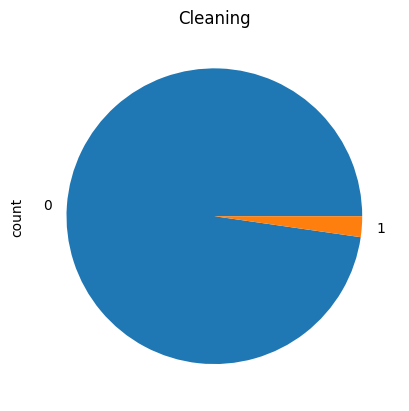

In [63]:
from imblearn.under_sampling import TomekLinks

sampling_strategy = "not minority"
tl = TomekLinks(sampling_strategy=sampling_strategy)
X_res, y_res = tl.fit_resample(X, y)
ax = y_res.value_counts().plot.pie()
_ = ax.set_title("Cleaning")
X_res.shape, y_res.shape, y_res.sum()

## Oversampling Fire Instances

### Random Over Sampler

((118092, 38), (118092,), np.int64(27252))

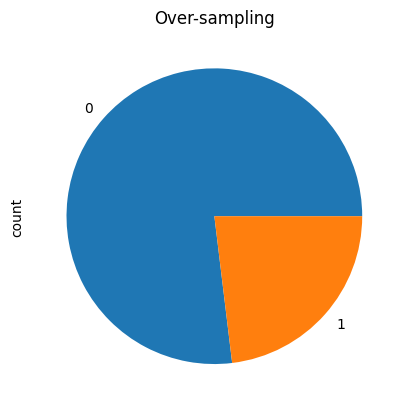

In [59]:
from imblearn.over_sampling import RandomOverSampler

sampling_strategy = 0.3
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(X, y)
ax = y_res.value_counts().plot.pie()
_ = ax.set_title("Over-sampling")
X_res.shape, y_res.shape, y_res.sum()

### SMOTE

((118092, 38), (118092,), np.int64(27252))

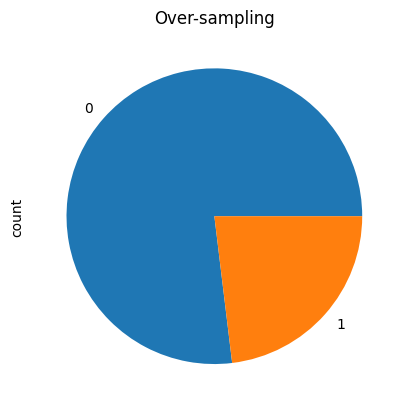

In [66]:
from imblearn.over_sampling import SMOTE

sampling_strategy = 0.3
smote = SMOTE(sampling_strategy=sampling_strategy)
X_res, y_res = smote.fit_resample(X, y)
ax = y_res.value_counts().plot.pie()
_ = ax.set_title("Over-sampling")
X_res.shape, y_res.shape, y_res.sum()